# Exploratory Data Analysis

### Imports

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from fontTools.ttLib.tables.S__i_l_f import attrs_attributes

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from scipy.stats import pearsonr, ttest_ind

### General Information on Dataset and Domain

#### Reading the dataset and describing it

In [114]:
df = pd.read_csv("../Dataset/predictive_maintenance_final.csv")
df.head(10)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type,prediction
0,300.8,310.3,1538,36.1,198,L,0
1,296.3,307.3,1368,49.5,10,M,0
2,298.6,309.1,1339,51.1,34,M,0
3,302.4,311.1,1634,34.2,184,L,0
4,297.9,307.7,1546,37.6,72,L,0
5,301.6,310.8,1290,65.3,63,M,0
6,298.2,308.2,1407,47.1,153,L,0
7,296.6,307.4,1465,47.8,187,L,0
8,298.6,309.6,1353,62.5,9,L,0
9,301.0,310.7,1391,45.0,123,L,0


In [115]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],1631.0,2126.669099,73755.964440,-25.0,298.30,300.1,301.40,2978980.9
Process temperature [K],1631.0,320.510791,293.111837,0.0,308.75,310.0,311.00,11111.0
Rotational speed [rpm],1631.0,1538.865113,214.979791,0.0,1425.00,1510.0,1614.50,5000.0
Torque [Nm],1631.0,39.915757,13.100062,0.0,33.00,39.4,46.45,360.0
Tool wear [min],1631.0,113.494788,109.264641,0.0,49.00,108.0,165.00,1980.0
prediction,1631.0,0.020846,0.142913,0.0,0.00,0.0,0.00,1.0


#### Dataset Shape

In [116]:
df.shape

(1631, 7)

#### Dataset Info

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      1631 non-null   float64
 1   Process temperature [K]  1631 non-null   float64
 2   Rotational speed [rpm]   1631 non-null   int64  
 3   Torque [Nm]              1631 non-null   float64
 4   Tool wear [min]          1631 non-null   int64  
 5   Type                     1628 non-null   object 
 6   prediction               1631 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 89.3+ KB


#### Variable categorization (count of numeric and categorical)

In [118]:
numeric_attr = df.select_dtypes(include=[np.number])
categorical_attr = df.select_dtypes(exclude=[np.number])

In [119]:
def variable_categorical():
    print("Numeric attributes:")
    print(numeric_attr.columns)
    print(f"Length of numeric attributes: {len(numeric_attr)}")
    print("\n\n***********************************\n\n")
    print("Categorical attributes:")
    print(categorical_attr.columns)
    print(f"Length of categorical attributes: {len(categorical_attr)}")

In [120]:
variable_categorical()

Numeric attributes:
Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'prediction'],
      dtype='object')
Length of numeric attributes: 1631


***********************************


Categorical attributes:
Index(['Type'], dtype='object')
Length of categorical attributes: 1631


#### Data Dictionary || Also changing the column names as per use-case

In [121]:
df.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type',
       'prediction'],
      dtype='object')

In [122]:
columns = {
    "Air temperature [K]": "air_temperature", # Ambient temperature
    "Process temperature [K]": "process_temperature", # Internal process temperature
    "Rotational speed [rpm]":"rotational_speed", # RPM
    "Torque [Nm]": "torque", # Torque applied
    "Tool wear [min]": "tool_wear", # Tool wear in minutes
    "Type": "type", # Machine type (L = Light, M = Medium, H = Heavy)
    "prediction": "machine_failure" # Target variable
    }

In [123]:
df.rename(columns=columns, inplace=True)
df.head(10)

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,type,machine_failure
0,300.8,310.3,1538,36.1,198,L,0
1,296.3,307.3,1368,49.5,10,M,0
2,298.6,309.1,1339,51.1,34,M,0
3,302.4,311.1,1634,34.2,184,L,0
4,297.9,307.7,1546,37.6,72,L,0
5,301.6,310.8,1290,65.3,63,M,0
6,298.2,308.2,1407,47.1,153,L,0
7,296.6,307.4,1465,47.8,187,L,0
8,298.6,309.6,1353,62.5,9,L,0
9,301.0,310.7,1391,45.0,123,L,0


In [124]:
df.machine_failure.value_counts()

machine_failure
0    1597
1      34
Name: count, dtype: int64

In [125]:
df['machine_failure'].value_counts(normalize=True)


machine_failure
0    0.979154
1    0.020846
Name: proportion, dtype: float64

"#### Unique values of categorical columns

In [126]:
numeric_attr = df.select_dtypes(include=[np.number])
categorical_attr = df.select_dtypes(exclude=[np.number])

In [127]:
categorical_attr.columns

Index(['type'], dtype='object')

In [128]:
for column in categorical_attr.columns:
    print(column)
    print(df[column].unique())
    print()

type
['L' 'M' 'H' nan]



### PRE-PROCESSING DATA ANALYSIS

#### Missing Values

In [129]:
df.isnull().sum()

air_temperature        0
process_temperature    0
rotational_speed       0
torque                 0
tool_wear              0
type                   3
machine_failure        0
dtype: int64

In [130]:
df.isna().sum()

air_temperature        0
process_temperature    0
rotational_speed       0
torque                 0
tool_wear              0
type                   3
machine_failure        0
dtype: int64

In [131]:
df['type'].value_counts()

type
L    993
M    478
H    157
Name: count, dtype: int64

**Since machine type is a categorical operational attribute and only 3 records had missing values, mode imputation was used to preserve dataset size and avoid bias caused by row deletion.**

In [132]:
mode_type = df["type"].mode()[0]
mode_type

'L'

In [133]:
df["type"].fillna(mode_type, inplace=True)

C:\Users\Debesh Pramanick\AppData\Local\Temp\ipykernel_11816\1022886954.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["type"].fillna(mode_type, inplace=True)


In [134]:
df.isna().sum()

air_temperature        0
process_temperature    0
rotational_speed       0
torque                 0
tool_wear              0
type                   0
machine_failure        0
dtype: int64

#### Duplicate Records

In [135]:
df.duplicated().sum()

0

#### Converting the object variables to categorical

In [136]:
df.dtypes

air_temperature        float64
process_temperature    float64
rotational_speed         int64
torque                 float64
tool_wear                int64
type                    object
machine_failure          int64
dtype: object

In [137]:
for column in categorical_attr.columns:
    df[column] = df[column].astype("category")

In [138]:
df.dtypes

air_temperature         float64
process_temperature     float64
rotational_speed          int64
torque                  float64
tool_wear                 int64
type                   category
machine_failure           int64
dtype: object

### EXPLORATORY DATA ANALYSIS (EDA)

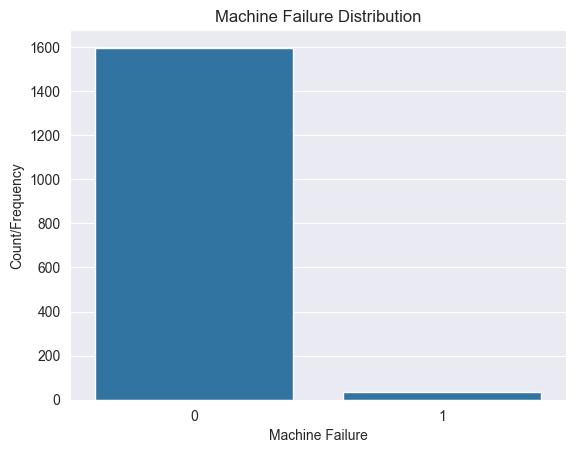

In [139]:
sns.countplot(x="machine_failure", data=df)
plt.title("Machine Failure Distribution")
plt.xlabel("Machine Failure")
plt.ylabel("Count/Frequency")
plt.show()

**Failure cases are rare i.e. class imbalance exists**

#### Machine Type vs Failure

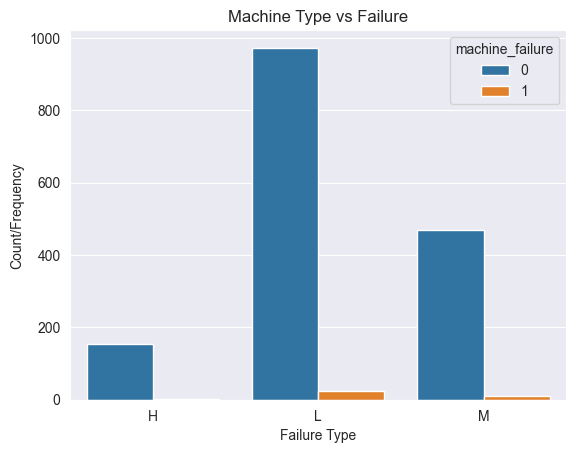

In [140]:
sns.countplot(x='type', hue='machine_failure', data=df)
plt.title("Machine Type vs Failure")
plt.xlabel("Failure Type")
plt.ylabel("Count/Frequency")
plt.show()


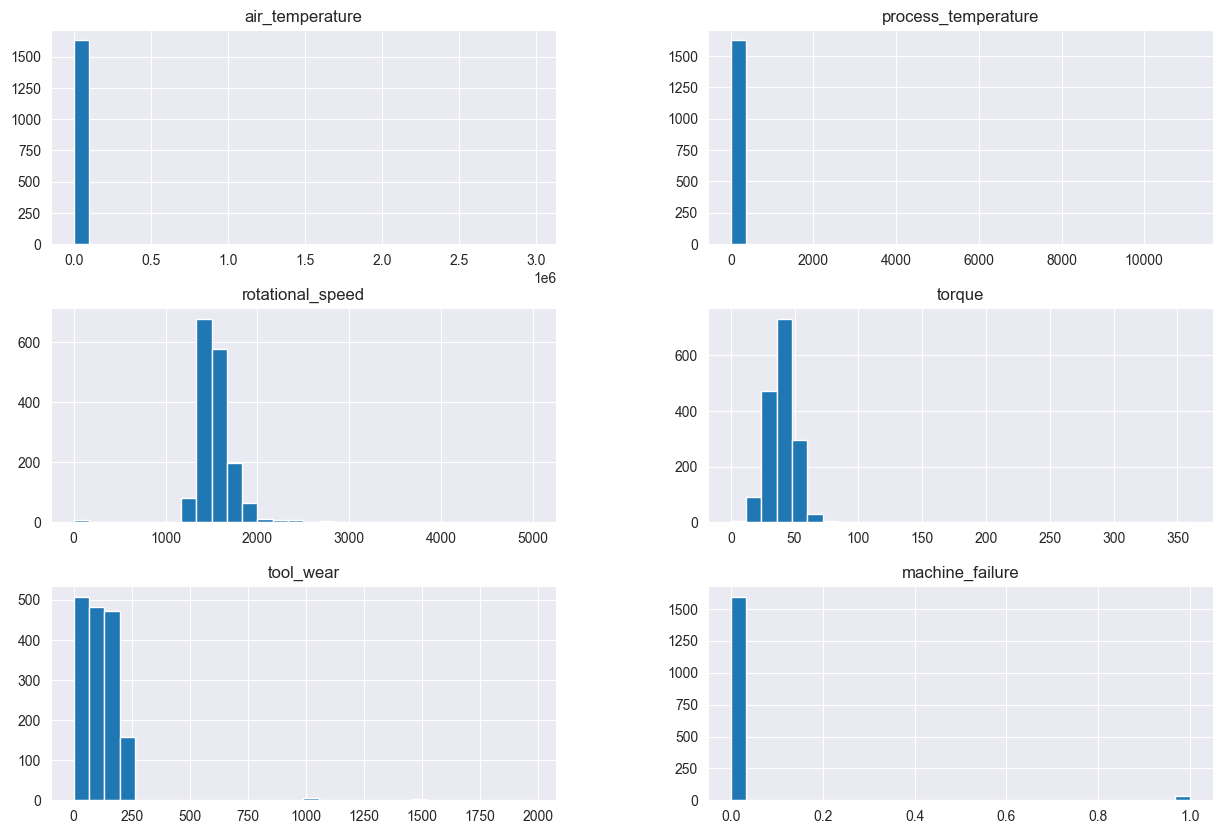

In [141]:
df[numeric_attr.columns].hist(figsize=(15,10), bins=30)
plt.show()


In [142]:
df.columns

Index(['air_temperature', 'process_temperature', 'rotational_speed', 'torque',
       'tool_wear', 'type', 'machine_failure'],
      dtype='object')

In [143]:
physical_attr = df[['air_temperature', 'process_temperature', 'rotational_speed', 'torque']]
physical_attr.head()

,air_temperature,process_temperature,rotational_speed,torque
0,300.8,310.3,1538,36.1
1,296.3,307.3,1368,49.5
2,298.6,309.1,1339,51.1
3,302.4,311.1,1634,34.2
4,297.9,307.7,1546,37.6


In [144]:
df.tool_wear.describe()

count    1631.000000
mean      113.494788
std       109.264641
min         0.000000
25%        49.000000
50%       108.000000
75%       165.000000
max      1980.000000
Name: tool_wear, dtype: float64

In [145]:
df["air_temperature"]

0       300.8
1       296.3
2       298.6
3       302.4
4       297.9
        ...  
1626    297.8
1627    302.0
1628    298.9
1629    298.4
1630    301.7
Name: air_temperature, Length: 1631, dtype: float64

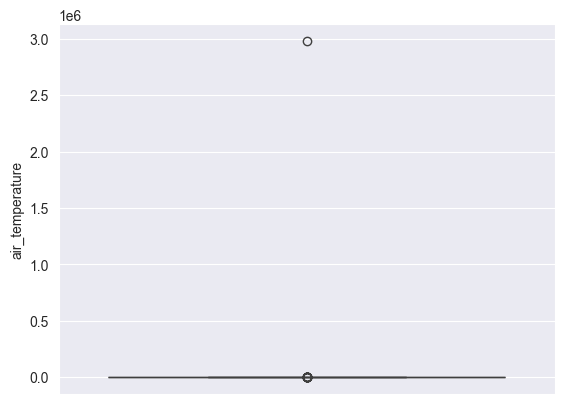

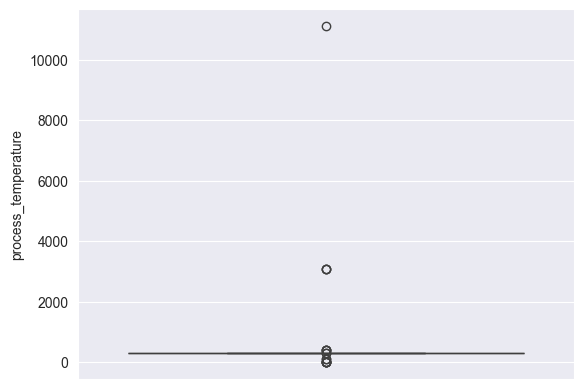

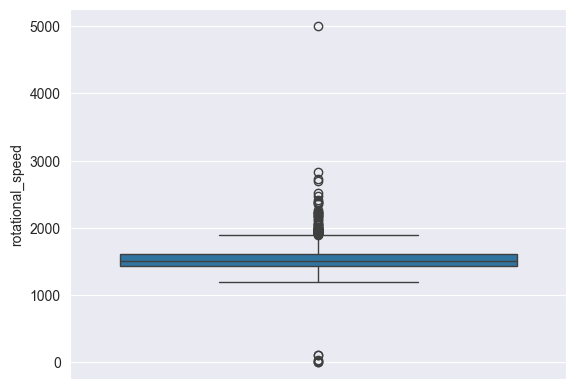

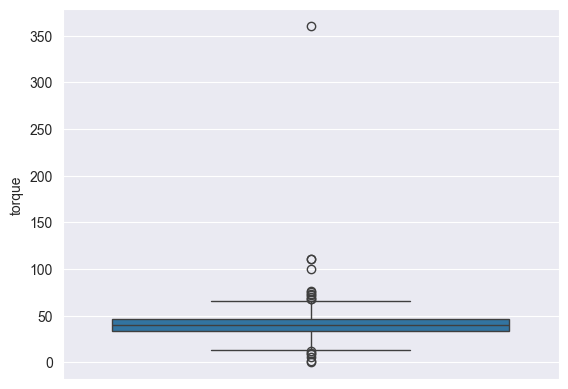

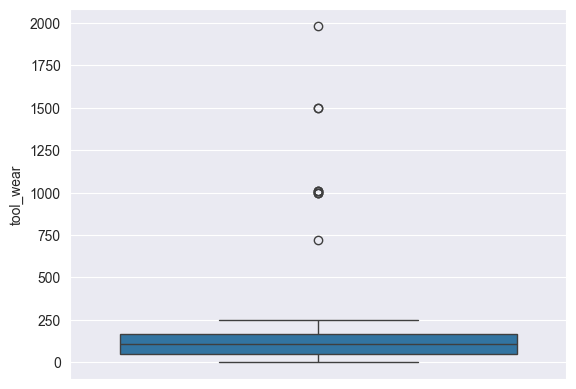

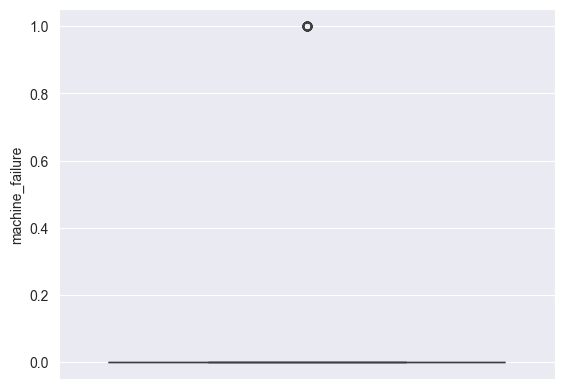

In [146]:
for column in numeric_attr.columns:
    sns.boxplot(df[column])
    plt.show()

In [147]:
df['machine_failure'].value_counts(normalize=True)


machine_failure
0    0.979154
1    0.020846
Name: proportion, dtype: float64

#### Outlier Detection (IQR)

In [148]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
numeric_features.remove('machine_failure')

In [149]:
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)

In [150]:
IQR = Q3-Q1

In [152]:
numeric_features

['air_temperature',
 'process_temperature',
 'rotational_speed',
 'torque',
 'tool_wear']

In [153]:
outlier_count = ((df[numeric_features] < (Q1 -1.5 * IQR)) | (df[numeric_features] > Q3 + 1.5 * IQR) ).sum()

In [154]:
outlier_count

air_temperature        21
process_temperature    18
rotational_speed       73
torque                 17
tool_wear              10
dtype: int64

#### Outlier Treatment (Capping)

In [155]:
for col in numeric_features:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    df[col] = np.clip(df[col], lower, upper)

#### Correlation & Multicollinearity

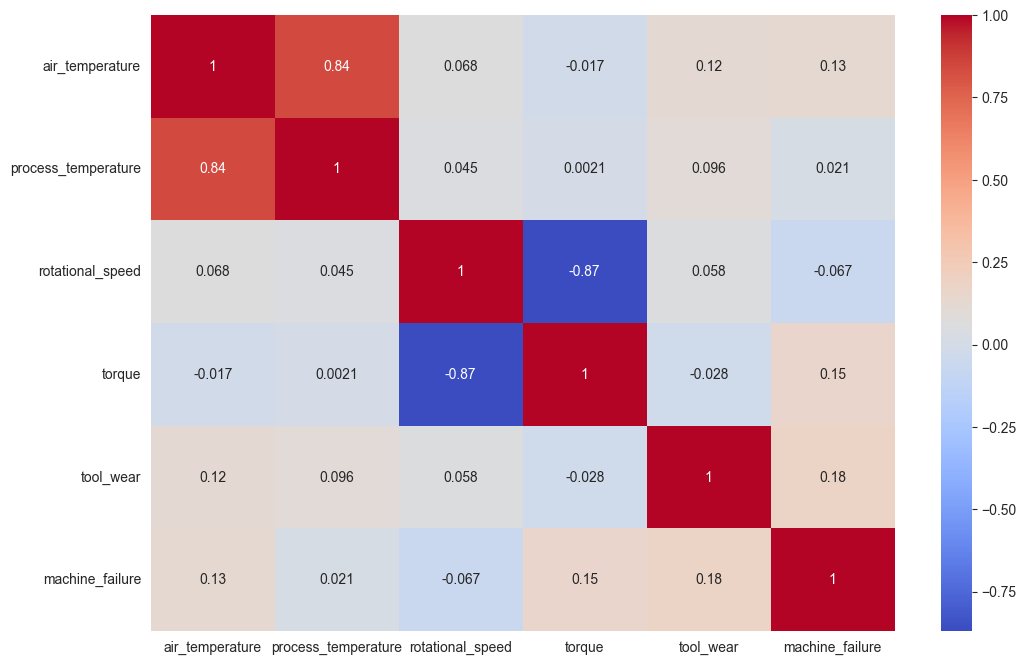

In [156]:
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_attr.columns].corr(), annot=True, cmap='coolwarm')
plt.show()

In [157]:
df['machine_failure'].value_counts(normalize=True)


machine_failure
0    0.979154
1    0.020846
Name: proportion, dtype: float64

#### VIF (Multicollinearity Check)

In [158]:
X_vif = df[numeric_attr.columns].drop(columns='machine_failure')

In [159]:
vif = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})

In [160]:
vif

,Feature,VIF
0,air_temperature,67590.412540
1,process_temperature,67847.984652
2,rotational_speed,438.830257
3,torque,69.886666
4,tool_wear,3.612584


### FEATURE ENGINEERING

#### Encoding the categorical attribute

In [161]:
df_encoded = pd.get_dummies(df, columns=["type"], drop_first=True)
df_encoded.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,type_L,type_M
0,300.8,310.3,1538.0,36.1,198,0,True,False
1,296.3,307.3,1368.0,49.5,10,0,False,True
2,298.6,309.1,1339.0,51.1,34,0,False,True
3,302.4,311.1,1634.0,34.2,184,0,True,False
4,297.9,307.7,1546.0,37.6,72,0,True,False


In [162]:
df_encoded.machine_failure.value_counts()

machine_failure
0    1597
1      34
Name: count, dtype: int64

#### Feature Creation

In [163]:
df_encoded["temp_diff"] = (df_encoded["air_temperature"] - df_encoded["process_temperature"])
df_encoded.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,type_L,type_M,temp_diff
0,300.8,310.3,1538.0,36.1,198,0,True,False,-9.5
1,296.3,307.3,1368.0,49.5,10,0,False,True,-11.0
2,298.6,309.1,1339.0,51.1,34,0,False,True,-10.5
3,302.4,311.1,1634.0,34.2,184,0,True,False,-8.7
4,297.9,307.7,1546.0,37.6,72,0,True,False,-9.8


In [164]:
df_encoded["power"] = (df_encoded["torque"] * df_encoded["rotational_speed"])
df_encoded.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,type_L,type_M,temp_diff,power
0,300.8,310.3,1538.0,36.1,198,0,True,False,-9.5,55521.8
1,296.3,307.3,1368.0,49.5,10,0,False,True,-11.0,67716.0
2,298.6,309.1,1339.0,51.1,34,0,False,True,-10.5,68422.9
3,302.4,311.1,1634.0,34.2,184,0,True,False,-8.7,55882.8
4,297.9,307.7,1546.0,37.6,72,0,True,False,-9.8,58129.6


#### Feature target split

In [165]:
X = df_encoded.drop(columns="machine_failure")
y = df_encoded["machine_failure"]

#### Scaling

In [166]:
y.value_counts(normalize=True)


machine_failure
0    0.979154
1    0.020846
Name: proportion, dtype: float64

In [167]:
df['machine_failure'].value_counts(normalize=True)


machine_failure
0    0.979154
1    0.020846
Name: proportion, dtype: float64

In [168]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [169]:
X_scaled

array([[ 0.40648903,  0.21730587,  0.03071707, ..., -0.64387164,
         0.44824634, -0.37284469],
       [-1.74784264, -1.734916  , -1.10196523, ...,  1.5531046 ,
        -0.85696036,  0.76480882],
       [-0.64673979, -0.56358288, -1.2951875 , ...,  1.5531046 ,
        -0.42189146,  0.8307588 ],
       ...,
       [-0.50311768,  0.08715775, -1.46842126, ...,  1.5531046 ,
        -1.03098791,  1.40503396],
       [-0.74248786, -1.34447163,  0.47712715, ..., -0.64387164,
         0.44824634, -0.91085622],
       [ 0.83735536, -0.10806444, -0.28243627, ..., -0.64387164,
         1.66643925, -0.08601032]])

#### Feature Importance (Random Forest)

In [170]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(X_scaled, y)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [171]:
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False)

tool_wear              0.231840
power                  0.206147
torque                 0.173479
temp_diff              0.159923
air_temperature        0.105196
rotational_speed       0.067003
process_temperature    0.052395
type_L                 0.002168
type_M                 0.001849
dtype: float64

#### Dimensionality Reduction (PCA)

In [177]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

((1631, 9), (1631, 6))

In [187]:
X_scaled.shape, X_pca.shape

((1631, 9), (1631, 6))

In [178]:
X_scaled

array([[ 0.40648903,  0.21730587,  0.03071707, ..., -0.64387164,
         0.44824634, -0.37284469],
       [-1.74784264, -1.734916  , -1.10196523, ...,  1.5531046 ,
        -0.85696036,  0.76480882],
       [-0.64673979, -0.56358288, -1.2951875 , ...,  1.5531046 ,
        -0.42189146,  0.8307588 ],
       ...,
       [-0.50311768,  0.08715775, -1.46842126, ...,  1.5531046 ,
        -1.03098791,  1.40503396],
       [-0.74248786, -1.34447163,  0.47712715, ..., -0.64387164,
         0.44824634, -0.91085622],
       [ 0.83735536, -0.10806444, -0.28243627, ..., -0.64387164,
         1.66643925, -0.08601032]])

### CLASS IMBALANCE HANDLING

In [179]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

### MODELLING (WITH TIME CONSIDERATION)

#### Train-Test Split

In [191]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)

#### Logistic Regression

In [198]:
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


##### Classification report for Logistic Regression

In [200]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       320
           1       0.89      0.90      0.90       319

    accuracy                           0.90       639
   macro avg       0.90      0.90      0.90       639
weighted avg       0.90      0.90      0.90       639



#### Decision Tree

In [205]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


##### Classification report for Decision Tree

In [206]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       320
           1       0.99      0.94      0.96       319

    accuracy                           0.97       639
   macro avg       0.97      0.97      0.97       639
weighted avg       0.97      0.97      0.97       639



#### Random Forest

In [207]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### Classification report for Random Forest

In [208]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       319

    accuracy                           1.00       639
   macro avg       1.00      1.00      1.00       639
weighted avg       1.00      1.00      1.00       639



#### SVM

In [211]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Classification report for SVM

In [213]:
print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       320
           1       0.99      1.00      0.99       319

    accuracy                           0.99       639
   macro avg       0.99      0.99      0.99       639
weighted avg       0.99      0.99      0.99       639

